## Imports

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.utils import compute_class_weight


from preprocessor import *
from data import *

In [12]:
## import data when available
data = pd.read_csv('wingman_data_proc_v3.csv')
data.set_index('id', inplace=True)

## Train test split

In [45]:
X = data.drop('category_no', axis=1)
y = data['category_no']

In [46]:
def calculate_class_weights(y):
    """
    Calculates the balanced class weights for a multiclass classification problem.
    Parameters:
    - y: array-like, shape (n_samples,)
        The target variable containing class labels.
    Returns:
    - class_weights: dict
        A dictionary containing the class weights for each class label.
    """
    class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y),
                                        y = y
                                    )
    return dict(zip(np.unique(y), class_weights))

class_weights = calculate_class_weights(y)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Baseline model

In [48]:
model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1, class_weight=class_weights)

In [49]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={1: 0.6621606205795117,
                                     2: 0.7494996449092904,
                                     3: 6.4280177187153935},
                       n_jobs=-1, random_state=1)

In [52]:
## baseline prediction

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.48722365776629345

In [51]:
data['category_no'].value_counts()
len(data['category_no'])

data['category_no'].value_counts()/len(data['category_no'])

1    0.503403
2    0.444741
3    0.051856
Name: category_no, dtype: float64

## Model building

In [53]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {1: 0.6621606205795117,
  2: 0.7494996449092904,
  3: 6.4280177187153935},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [54]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2500, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 200, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 25, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10, 15, 20, 25, 30]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [55]:
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 10, cv = 5, random_state=1, n_jobs = 1, verbose=3)

model_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=8, min_samples_split=25, n_estimators=900;, score=0.479 total time=  10.5s


KeyboardInterrupt: ignored

In [23]:
model_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 25,
 'min_samples_leaf': 8,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': False}

In [24]:
model_random.best_score_

0.5189490017977103

In [29]:
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [None],
    'max_features': ['log2'],
    'min_samples_leaf': [7, 7.5, 8, 8.5],
    'min_samples_split': [23,24,25,26],
    'n_estimators': [850, 900, 925, 950]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid,
                          cv = 3, verbose = 3)

In [30]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=7, min_samples_split=23, n_estimators=850;, score=0.514 total time=   7.6s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=7, min_samples_split=23, n_estimators=850;, score=0.506 total time=   6.4s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=7, min_samples_split=23, n_estimators=850;, score=0.508 total time=   6.9s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=7, min_samples_split=23, n_estimators=900;, score=0.515 total time=   7.0s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=7, min_samples_split=23, n_estimators=900;, score=0.505 total time=   7.0s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=7, min_samples_split=23, n_estimators=900;, score=0.508 total time=   7

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['log2'],
                         'min_samples_leaf': [7, 7.5, 8, 8.5],
                         'min_samples_split': [23, 24, 25, 26],
                         'n_estimators': [850, 900, 925, 950]},
             verbose=3)

In [32]:
grid_search.best_params_
grid_search.best_score_

0.5141521805154109

In [75]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

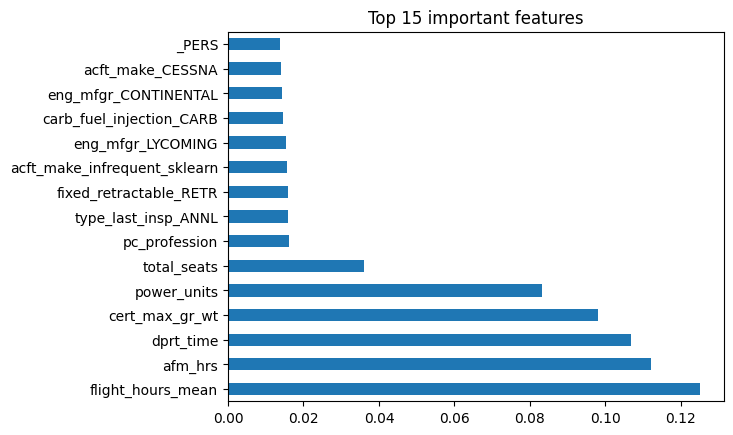

In [76]:
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [80]:
feat_importances.nlargest(20)

flight_hours_mean               0.125146
afm_hrs                         0.112192
dprt_time                       0.106696
cert_max_gr_wt                  0.098032
power_units                     0.083192
total_seats                     0.036075
pc_profession                   0.016171
type_last_insp_ANNL             0.016016
fixed_retractable_RETR          0.015887
acft_make_infrequent_sklearn    0.015722
eng_mfgr_LYCOMING               0.015352
carb_fuel_injection_CARB        0.014692
eng_mfgr_CONTINENTAL            0.014351
acft_make_CESSNA                0.014124
_PERS                           0.013717
dest_apt_id                     0.013168
carb_fuel_injection_FINJ        0.013123
second_pilot                    0.012706
acft_make_PIPER                 0.011719
type_last_insp_100H             0.010755
dtype: float64